<a href="https://colab.research.google.com/github/Rocking-Priya/704-fall-projects-2025/blob/main/Week_3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DX 704 Week 3 Project
This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [ ]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [ ]:
bandit0 = BanditProblem(0)

In [ ]:
bandit0.get_num_arms()

3

In [ ]:
bandit0.get_reward(arm=0)

1.8255111545554434

In [ ]:
print("ns:", bandit0.ns)
print("ps:", bandit0.ps.round(4))


ns: [8 6 5]
ps: [0.2082 0.2033 0.3627]


Arm 0: mean=0.8339, std=0.8253, frac_zero=0.1575, max=6.7825


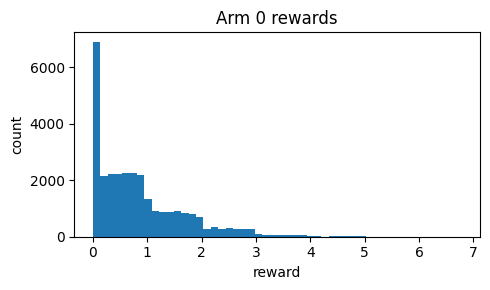

Arm 1: mean=0.6074, std=0.6706, frac_zero=0.2560, max=4.8546


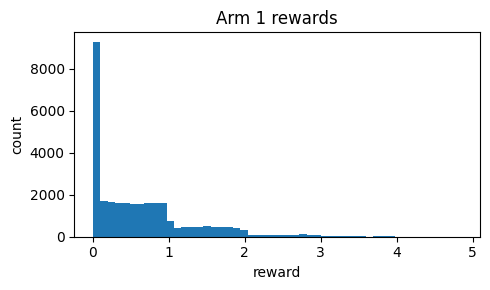

Arm 2: mean=0.8991, std=0.8031, frac_zero=0.1044, max=4.9959


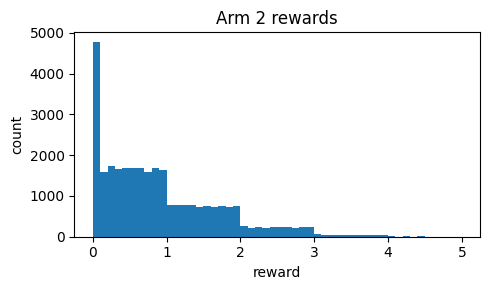

In [ ]:
# YOUR CHANGES HERE

import matplotlib.pyplot as plt
n_sims = 30000
k = bandit0.get_num_arms()
samples = [np.array([bandit0.get_reward(a) for _ in range(n_sims)]) for a in range(k)]

for a, s in enumerate(samples):
    print(f"Arm {a}: mean={s.mean():.4f}, std={s.std(ddof=1):.4f}, frac_zero={(s==0).mean():.4f}, max={s.max():.4f}")
    plt.figure(figsize=(5,3))
    plt.hist(s, bins=50)
    plt.title(f"Arm {a} rewards")
    plt.xlabel("reward"); plt.ylabel("count"); plt.tight_layout(); plt.show()


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [ ]:
# YOUR CHANGES HERE

# Re-run the UCB1 implementation
import math
import csv
from pathlib import Path

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x

# Instantiate bandit with requested seed
seed = 2025002
bandit = BanditProblem(seed)

# Parameters
T = 1000
k = bandit.get_num_arms()
max_ns = bandit.ns.max()

# UCB1 (normalized rewards by max_ns)
counts = np.zeros(k, dtype=int)
sums = np.zeros(k, dtype=float)

history = []  # list of (action, reward) in order taken

# Initialization: pull each arm once (if T < k, only pull up to T)
t = 0
for a in range(k):
    if t >= T:
        break
    r = bandit.get_reward(a)
    counts[a] += 1
    sums[a] += r
    history.append((a, r))
    t += 1

# Main loop
while t < T:
    # compute normalized means (safe divide)
    means = sums / counts
    #means_norm = means / max_ns  # normalize to [0,1] (approx)
    # compute UCB scores; note t in formula typically counts total pulls so far
    # here we'll use current total pulls t (>=k)
    bonuses = np.sqrt((2 * math.log(t)) / counts)
    ucb_scores = means + bonuses
    # pick arm with highest UCB score
    arm = int(np.argmax(ucb_scores))
    r = bandit.get_reward(arm)
    counts[arm] += 1
    sums[arm] += r
    history.append((arm, r))
    t += 1



# Print brief summary
total_reward = sum(r for (_, r) in history)
print("Bandit ns:", bandit.ns.tolist())
print("Bandit ps:", np.round(bandit.ps,4).tolist())
print("Pull counts:", counts.tolist())
print(f"Total reward over {T} rounds: {total_reward:.6f}")



Bandit ns: [4, 4, 1]
Bandit ps: [0.2814, 0.269, 0.3944]
Pull counts: [637, 314, 49]
Total reward over 1000 rounds: 542.250453


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [ ]:
# YOUR CHANGES HERE

# Save history.tsv
out_path = Path("/content/history.tsv")
with out_path.open("w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["action", "reward"])
    for a, r in history:
        writer.writerow([a, f"{r:.10f}"])

In [ ]:
from google.colab import files

# This will prompt a download in your browser
files.download("/content/history.tsv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns arm, min_reward, mean_reward, max_reward.

In [ ]:
# YOUR CHANGES HERE

# 1. Collect rewards by arm
k = max(a for a, _ in history) + 1  # number of arms
arm_rewards = [[] for _ in range(k)]

for a, r in history:
    arm_rewards[a].append(r)

# 2. Compute statistics
stats = []
for arm in range(k):
    rewards = arm_rewards[arm]
    min_r = min(rewards)
    mean_r = np.mean(rewards)
    max_r = max(rewards)
    stats.append((arm, min_r, mean_r, max_r))



print("Saved actions.tsv")

# 3. Save to actions.tsv with required columns
out_path = Path("/content/actions.tsv")
with out_path.open("w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["arm", "action", "min_reward", "mean_reward", "max_reward"])
    for arm, min_r, mean_r, max_r in stats:
        writer.writerow([arm, arm, f"{min_r:.10f}", f"{mean_r:.10f}", f"{max_r:.10f}"])



Saved actions.tsv


In [ ]:
import pandas as pd

# Read the TSV we just saved
df = pd.read_csv("/content/actions.tsv", sep="\t")

# Print nicely
print(df.to_string(index=False))

 arm  action  min_reward  mean_reward  max_reward
   0       0         0.0     0.583870    3.761461
   1       1         0.0     0.513534    2.707422
   2       2         0.0     0.185208    0.966617


In [ ]:
files.download("/content/actions.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [ ]:
# YOUR CHANGES HERE

# 1. Get mean reward per arm from stats (Part 3)
means = [mean_r for (_, _, mean_r, _) in stats]
best_mean = max(means)
K = len(means)

# 2. Compute expected rewards for each strategy
strategy_rewards = {}

# uniform: pick arms uniformly at random
uniform_reward = 1000 * np.mean(means)
strategy_rewards['uniform'] = uniform_reward

# just-i: always pick arm i
for i, m in enumerate(means):
    strategy_rewards[f'just-{i}'] = 1000 * m

# actual: sum of rewards from Part 2
actual_reward = sum(r for (_, r) in history)
strategy_rewards['actual'] = actual_reward

# 3. Compute regret = 1000*best_mean - strategy_reward
strategy_regret = {s: 1000*best_mean - r for s, r in strategy_rewards.items()}

Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [ ]:
# YOUR CHANGES HERE

# 4. Save to strategies.tsv
out_path = Path("/content/strategies.tsv")
with out_path.open("w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["strategy", "regret"])
    for s, r in strategy_regret.items():
        writer.writerow([s, f"{r:.10f}"])

print("Saved strategies.tsv")
print("Strategy regrets:")
for s, r in strategy_regret.items():
    print(f"{s}: {r:.6f}")


Saved strategies.tsv
Strategy regrets:
uniform: 156.332860
just-0: 0.000000
just-1: 70.336179
just-2: 398.662400
actual: 41.620018


In [ ]:
files.download("/content/strategies.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.